# TODO:
* Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* checking hyperparameters from paper
* checking used parameters
* * Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!nvidia-smi

Sat May  1 14:03:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   34C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Auswahl des Spiels

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


## Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

## Max And Skip Env Wrapper

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

## Noop Reset Env Wrapper

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

## Scaled Float Frame Wrapper

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

## Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

## Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

## Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

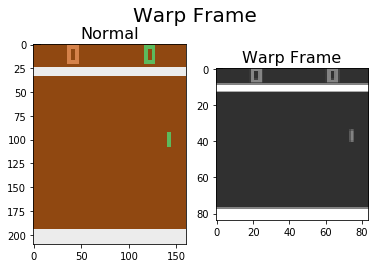

In [11]:
""" 
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

## Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

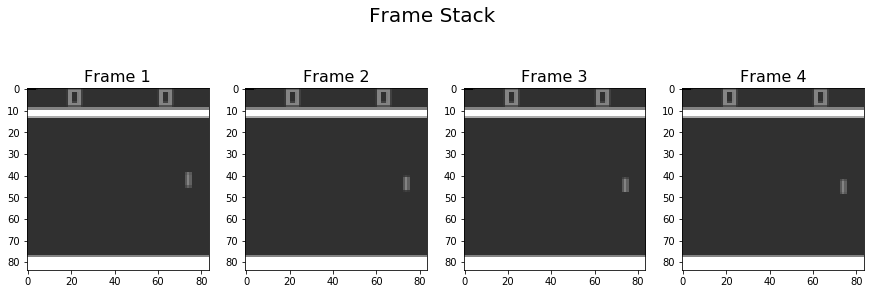

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

## Erstellen des Environments

In [14]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

""" saving the properties for csv """

MODE = "NoEpisodicLife_NoClipReward_lr_1e-3_5e-3"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Pong-v0/NoEpisodicLife_NoClipReward_lr_1e-3_5e-3/


# Actor Network und Critic Network

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Network Parameter
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
ACTOR_OUTPUT = env.action_space.n # Anzahl der möglichen Aktionen
CRITIC_OUTPUT = 1 # Bewertung der gewählten Aktion
ACTOR_LEARNING_RATE = 1e-3
CRITIC_LEARNING_RATE = 5e-3

# neuronales Netz
net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation("relu")(x)


'''Aufspalten des Netzes in Actor und Critic'''

# Actor - wählt eine Aktion
actor_x = Dense(ACTOR_OUTPUT)(x)
actor_output = Activation("softmax")(actor_x)

ACTOR = Model(inputs=net_input, outputs=actor_output)
ACTOR.compile(loss="categorical_crossentropy", optimizer=Adam(lr=ACTOR_LEARNING_RATE))

# Critic - bewertet gewählte Aktion
critic_x = Dense(CRITIC_OUTPUT)(x)
critic_output = Activation("linear")(critic_x)

CRITIC = Model(inputs=net_input, outputs=critic_output)
CRITIC.compile(loss="mse", optimizer=Adam(lr=CRITIC_LEARNING_RATE))

# Aktion wählen

In [16]:
def get_action(state):
    policy = ACTOR.predict(state)[0]
    action = np.random.choice(env.action_space.n, p=policy) # Aktionen, welche Wahrscheinlichkeit zu Aktion
    return action

In [17]:
GAMMA = 0.99

def update_policy(state, action, reward, next_state, done):
    values = np.zeros(shape=(1, CRITIC_OUTPUT))
    advantages = np.zeros(shape=(1, ACTOR_OUTPUT))
    
    # State bewerten
    value = CRITIC.predict(state)[0]
    next_value = CRITIC.predict(next_state)[0]
    
    if done:
        advantages[0][action] = reward - value
        values[0][0] = reward
    else:
        advantages[0][action] = (reward + GAMMA * next_value) - value
        values[0][0] = reward + GAMMA * next_value
        
    # Trainieren der Netze
    ACTOR.fit(state, advantages, verbose=0)
    CRITIC.fit(state, values, verbose=0)

# Training /Spielen

In [18]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-21.0

In [19]:
EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        update_policy(state, action, reward, next_state, done)
        
        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD)

            # Übernahme des höchsten Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # trainierte Gewichte speichern
                import os
                try:
                    os.makedirs(PATH)
                except FileExistsError:
                    # Pfad existiert bereits
                    pass
                ACTOR.save_weights(PATH + "Best_ACTOR.h5")
                CRITIC.save_weights(PATH + "Best_CRITIC.h5")

W0501 14:03:49.650184 140001602852672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: -20.0 	Mean: -20.0 	BestMean: -21.0
Episode: 2 	Reward: -21.0 	Mean: -20.5 	BestMean: -20.0
Episode: 3 	Reward: -21.0 	Mean: -20.67 	BestMean: -20.0
Episode: 4 	Reward: -20.0 	Mean: -20.5 	BestMean: -20.0
Episode: 5 	Reward: -19.0 	Mean: -20.2 	BestMean: -20.0
Episode: 6 	Reward: -20.0 	Mean: -20.17 	BestMean: -20.0
Episode: 7 	Reward: -20.0 	Mean: -20.14 	BestMean: -20.0
Episode: 8 	Reward: -19.0 	Mean: -20.0 	BestMean: -20.0
Episode: 9 	Reward: -20.0 	Mean: -20.0 	BestMean: -20.0
Episode: 10 	Reward: -21.0 	Mean: -20.1 	BestMean: -20.0
Episode: 11 	Reward: -20.0 	Mean: -20.1 	BestMean: -20.0
Episode: 12 	Reward: -20.0 	Mean: -20.0 	BestMean: -20.0
Episode: 13 	Reward: -19.0 	Mean: -19.8 	BestMean: -20.0
Episode: 14 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.8
Episode: 15 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.8
Episode: 16 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.8
Episode: 17 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.8
Episode: 18 	Reward: -20.0 	Mean: -20

Episode: 145 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 146 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.4
Episode: 147 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.4
Episode: 148 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.4
Episode: 149 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.4
Episode: 150 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.4
Episode: 151 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.4
Episode: 152 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.4
Episode: 153 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.4
Episode: 154 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.4
Episode: 155 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.4
Episode: 156 	Reward: -18.0 	Mean: -20.4 	BestMean: -19.4
Episode: 157 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.4
Episode: 158 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.4
Episode: 159 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.4
Episode: 160 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.4
Episode: 161 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.4
Episode: 162 	

Episode: 287 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.4
Episode: 288 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.4
Episode: 289 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 290 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.4
Episode: 291 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 292 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.4
Episode: 293 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.4
Episode: 294 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.4
Episode: 295 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 296 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 297 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.4
Episode: 298 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.4
Episode: 299 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.4
Episode: 300 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.4
Episode: 301 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.4
Episode: 302 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.4
Episode: 303 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.4
Episode: 304 	

Episode: 429 	Reward: -20.0 	Mean: -19.6 	BestMean: -19.3
Episode: 430 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.3
Episode: 431 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.3
Episode: 432 	Reward: -19.0 	Mean: -19.7 	BestMean: -19.3
Episode: 433 	Reward: -21.0 	Mean: -19.8 	BestMean: -19.3
Episode: 434 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.3
Episode: 435 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.3
Episode: 436 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.3
Episode: 437 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 438 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 439 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 440 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.3
Episode: 441 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 442 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.3
Episode: 443 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.3
Episode: 444 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.3
Episode: 445 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.3
Episode: 446 	

Episode: 571 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 572 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.3
Episode: 573 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.3
Episode: 574 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.3
Episode: 575 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 576 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.3
Episode: 577 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.3
Episode: 578 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 579 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 580 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 581 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.3
Episode: 582 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.3
Episode: 583 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.3
Episode: 584 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.3
Episode: 585 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 586 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.3
Episode: 587 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.3
Episode: 588 	

Episode: 713 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.3
Episode: 714 	Reward: -19.0 	Mean: -19.7 	BestMean: -19.3
Episode: 715 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.3
Episode: 716 	Reward: -21.0 	Mean: -19.8 	BestMean: -19.3
Episode: 717 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.3
Episode: 718 	Reward: -18.0 	Mean: -19.5 	BestMean: -19.3
Episode: 719 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.3
Episode: 720 	Reward: -21.0 	Mean: -19.8 	BestMean: -19.3
Episode: 721 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.3
Episode: 722 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.3
Episode: 723 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.3
Episode: 724 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.3
Episode: 725 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.3
Episode: 726 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 727 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.3
Episode: 728 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 729 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 730 	

Episode: 855 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.3
Episode: 856 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.3
Episode: 857 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.3
Episode: 858 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.3
Episode: 859 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.3
Episode: 860 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.3
Episode: 861 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.3
Episode: 862 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.3
Episode: 863 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.3
Episode: 864 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.3
Episode: 865 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.3
Episode: 866 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.3
Episode: 867 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.3
Episode: 868 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.3
Episode: 869 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.3
Episode: 870 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.3
Episode: 871 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.3
Episode: 872 	

Episode: 997 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.3
Episode: 998 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.3
Episode: 999 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1000 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1001 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1002 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1003 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1004 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1005 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1006 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1007 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.3
Episode: 1008 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.3
Episode: 1009 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.3
Episode: 1010 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.3
Episode: 1011 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.3
Episode: 1012 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1013 	Reward: -17.0 	Mean: -20.1 	BestMean: -19.3


Episode: 1136 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1137 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1138 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.3
Episode: 1139 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1140 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1141 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1142 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1143 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.3
Episode: 1144 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.3
Episode: 1145 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.3
Episode: 1146 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.3
Episode: 1147 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1148 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1149 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1150 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.3
Episode: 1151 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.3
Episode: 1152 	Reward: -20.0 	Mean: -20.2 	BestMean: -19

Episode: 1275 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1276 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1277 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1278 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1279 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1280 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1281 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1282 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1283 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1284 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1285 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1286 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1287 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1288 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1289 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1290 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1291 	Reward: -20.0 	Mean: -20.2 	BestMean: -19

Episode: 1414 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1415 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1416 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1417 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1418 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 1419 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 1420 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1421 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1422 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1423 	Reward: -18.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1424 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1425 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1426 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1427 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1428 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1429 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1430 	Reward: -20.0 	Mean: -20.3 	BestMean: -19

Episode: 1553 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1554 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1555 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1556 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1557 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1558 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1559 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1560 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1561 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1562 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1563 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1564 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1565 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1566 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1567 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1568 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1569 	Reward: -21.0 	Mean: -20.3 	BestMean: -19

Episode: 1692 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1693 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1694 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1695 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1696 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1697 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1698 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1699 	Reward: -18.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1700 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1701 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1702 	Reward: -18.0 	Mean: -19.8 	BestMean: -19.0
Episode: 1703 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.0
Episode: 1704 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1705 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1706 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 1707 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1708 	Reward: -19.0 	Mean: -19.7 	BestMean: -19

Episode: 1831 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1832 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1833 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 1834 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1835 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1836 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1837 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1838 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1839 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1840 	Reward: -18.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1841 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1842 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 1843 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 1844 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1845 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1846 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 1847 	Reward: -20.0 	Mean: -20.0 	BestMean: -19

Episode: 1970 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1971 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1972 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 1973 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1974 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1975 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1976 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1977 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1978 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1979 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1980 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1981 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1982 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1983 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 1984 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 1985 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 1986 	Reward: -20.0 	Mean: -20.4 	BestMean: -19

Episode: 2109 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2110 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2111 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2112 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2113 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2114 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2115 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2116 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2117 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2118 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2119 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2120 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2121 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2122 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2123 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2124 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2125 	Reward: -21.0 	Mean: -20.6 	BestMean: -19

Episode: 2248 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2249 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2250 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2251 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2252 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2253 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2254 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2255 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2256 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 2257 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.0
Episode: 2258 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2259 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 2260 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2261 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2262 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2263 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2264 	Reward: -20.0 	Mean: -20.3 	BestMean: -19

Episode: 2387 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2388 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 2389 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 2390 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2391 	Reward: -18.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2392 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2393 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2394 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2395 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2396 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2397 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2398 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2399 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2400 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2401 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2402 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2403 	Reward: -20.0 	Mean: -20.4 	BestMean: -19

Episode: 2526 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2527 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2528 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2529 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2530 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2531 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2532 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2533 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2534 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2535 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2536 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2537 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2538 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2539 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2540 	Reward: -18.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2541 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2542 	Reward: -20.0 	Mean: -20.1 	BestMean: -19

Episode: 2665 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2666 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2667 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2668 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2669 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2670 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2671 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 2672 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2673 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2674 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2675 	Reward: -18.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2676 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2677 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2678 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2679 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2680 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2681 	Reward: -21.0 	Mean: -20.0 	BestMean: -19

Episode: 2804 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2805 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2806 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2807 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2808 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2809 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.0
Episode: 2810 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 2811 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2812 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2813 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2814 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2815 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2816 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2817 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 2818 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2819 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2820 	Reward: -20.0 	Mean: -20.4 	BestMean: -19

Episode: 2943 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.0
Episode: 2944 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2945 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 2946 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 2947 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2948 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2949 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2950 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 2951 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2952 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2953 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 2954 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2955 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2956 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2957 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 2958 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 2959 	Reward: -21.0 	Mean: -20.3 	BestMean: -19

Episode: 3082 	Reward: -19.0 	Mean: -20.5 	BestMean: -19.0
Episode: 3083 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 3084 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 3085 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 3086 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3087 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3088 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3089 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3090 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3091 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3092 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.0
Episode: 3093 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3094 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3095 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3096 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3097 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.0
Episode: 3098 	Reward: -21.0 	Mean: -19.9 	BestMean: -19

Episode: 3221 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.0
Episode: 3222 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.0
Episode: 3223 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 3224 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.0
Episode: 3225 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3226 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3227 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3228 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3229 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3230 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3231 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3232 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3233 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3234 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3235 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.0
Episode: 3236 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 3237 	Reward: -20.0 	Mean: -20.0 	BestMean: -19

Episode: 3360 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3361 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3362 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3363 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3364 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3365 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.0
Episode: 3366 	Reward: -20.0 	Mean: -20.8 	BestMean: -19.0
Episode: 3367 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.0
Episode: 3368 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.0
Episode: 3369 	Reward: -21.0 	Mean: -20.8 	BestMean: -19.0
Episode: 3370 	Reward: -20.0 	Mean: -20.7 	BestMean: -19.0
Episode: 3371 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 3372 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 3373 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 3374 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 3375 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 3376 	Reward: -20.0 	Mean: -20.5 	BestMean: -19

Episode: 3499 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3500 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3501 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3502 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 3503 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3504 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3505 	Reward: -18.0 	Mean: -19.8 	BestMean: -19.0
Episode: 3506 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 3507 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 3508 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3509 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3510 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3511 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3512 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3513 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 3514 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 3515 	Reward: -21.0 	Mean: -20.6 	BestMean: -19

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 4002 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4003 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4004 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4005 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4006 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4007 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4008 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4009 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4010 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4011 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4012 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4013 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4014 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4015 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4016 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4017 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4018 	Reward: -20.0 	Mean: -20.2 	BestMean: -19

Episode: 4141 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4142 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4143 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4144 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4145 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4146 	Reward: -20.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4147 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4148 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4149 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4150 	Reward: -19.0 	Mean: -19.8 	BestMean: -19.0
Episode: 4151 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.0
Episode: 4152 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4153 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 4154 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4155 	Reward: -20.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4156 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4157 	Reward: -21.0 	Mean: -20.2 	BestMean: -19

Episode: 4280 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4281 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4282 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4283 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4284 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 4285 	Reward: -19.0 	Mean: -19.6 	BestMean: -19.0
Episode: 4286 	Reward: -20.0 	Mean: -19.5 	BestMean: -19.0
Episode: 4287 	Reward: -21.0 	Mean: -19.7 	BestMean: -19.0
Episode: 4288 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4289 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4290 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4291 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4292 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4293 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4294 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4295 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 4296 	Reward: -19.0 	Mean: -20.6 	BestMean: -19

Episode: 4419 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4420 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4421 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4422 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4423 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4424 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4425 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4426 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4427 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4428 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4429 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4430 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4431 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 4432 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4433 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4434 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 4435 	Reward: -21.0 	Mean: -20.7 	BestMean: -19

Episode: 4558 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4559 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4560 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4561 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4562 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4563 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4564 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4565 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4566 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4567 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4568 	Reward: -21.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4569 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4570 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4571 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4572 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4573 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4574 	Reward: -19.0 	Mean: -20.3 	BestMean: -19

Episode: 4697 	Reward: -19.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4698 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4699 	Reward: -20.0 	Mean: -19.8 	BestMean: -19.0
Episode: 4700 	Reward: -21.0 	Mean: -19.8 	BestMean: -19.0
Episode: 4701 	Reward: -20.0 	Mean: -19.7 	BestMean: -19.0
Episode: 4702 	Reward: -21.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4703 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4704 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4705 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4706 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4707 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4708 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4709 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4710 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4711 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4712 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4713 	Reward: -20.0 	Mean: -20.4 	BestMean: -19

Episode: 4836 	Reward: -20.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4837 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4838 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 4839 	Reward: -20.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4840 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4841 	Reward: -21.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4842 	Reward: -21.0 	Mean: -20.7 	BestMean: -19.0
Episode: 4843 	Reward: -19.0 	Mean: -20.6 	BestMean: -19.0
Episode: 4844 	Reward: -19.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4845 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4846 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4847 	Reward: -19.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4848 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4849 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4850 	Reward: -18.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4851 	Reward: -21.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4852 	Reward: -20.0 	Mean: -19.8 	BestMean: -19

Episode: 4975 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4976 	Reward: -20.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4977 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4978 	Reward: -21.0 	Mean: -20.4 	BestMean: -19.0
Episode: 4979 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4980 	Reward: -21.0 	Mean: -20.5 	BestMean: -19.0
Episode: 4981 	Reward: -19.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4982 	Reward: -19.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4983 	Reward: -21.0 	Mean: -20.1 	BestMean: -19.0
Episode: 4984 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4985 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4986 	Reward: -20.0 	Mean: -20.3 	BestMean: -19.0
Episode: 4987 	Reward: -20.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4988 	Reward: -21.0 	Mean: -20.2 	BestMean: -19.0
Episode: 4989 	Reward: -19.0 	Mean: -20.0 	BestMean: -19.0
Episode: 4990 	Reward: -20.0 	Mean: -19.9 	BestMean: -19.0
Episode: 4991 	Reward: -20.0 	Mean: -20.0 	BestMean: -19

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST)), 
               columns =['Rewards', 'Mean Reward']) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [ ]:
ACTOR.save_weights(PATH + "End.h5")
CRITIC.save_weights(PATH + "End.h5")

# Auswertung

In [ ]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# Spielen

In [ ]:
import gym
from IPython import display
import matplotlib

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(ACTOR.predict(state))
        state, reward, done, info = env.step(action)